# Naive Bayes

The goal of this problem is to build naive bayes (NB) models to classify whether each message is spam or not.

The data used in this problem provide frequencies of words for each message.

The column “label” is the target variable, indicating whether each message is spam or not (the label “ham” means that it is not a spam message.).

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [3]:
df = pd.read_csv("./spam_small.csv")
df.head()

,100,1000,150,150p,150ppm,16,18,1st,2000,2nd,...,weekly,well,went,win,word,work,would,yeah,yes,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,spam
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,spam


In [4]:
x = df.drop("label", axis=1)
y = df["label"]

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y)

## Part 1: Bernoulli NB

To build a Bernoulli NB, if a certain word is used in a message, the values of the variables are set to 1; otherwise, they are set to 0.

1-(1) After the conversion, train a Bernoulli NB using training set (alpha=1). Prior probabilities of classes are proportional to ratios of classes in training set. Then, calculate the overall accuracy and accuracy values corresponding to each target class for the training and validation sets, respectively.

In [6]:
model = BernoulliNB(alpha=1)

In [9]:
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_valid)


In [11]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    accuracy = correct_predictions / len(y_true)
    return accuracy

def calculate_class_accuracy(y_true, y_pred):
    unique_classes = np.unique(y_true)
    class_accuracies = {}
    for cls in unique_classes:
        cls_indices = (y_true == cls)
        cls_correct_predictions = np.sum(y_true[cls_indices] == y_pred[cls_indices])
        cls_accuracy = cls_correct_predictions / np.sum(cls_indices)
        class_accuracies[cls] = cls_accuracy
    return class_accuracies

In [17]:
# 전체 정확도 계산
train_accuracy = calculate_accuracy(y_train, y_train_pred)
valid_accuracy = calculate_accuracy(y_valid, y_valid_pred)

# 각 클래스별 정확도 계산
train_class_accuracies = calculate_class_accuracy(y_train, y_train_pred)
valid_class_accuracies = calculate_class_accuracy(y_valid, y_valid_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")

print("\nTraining Set Class-wise Accuracy:")
for label, accuracy in train_class_accuracies.items():
    print(f"Class {label}: {accuracy:.4f}")

print("\nValidation Set Class-wise Accuracy:")
for label, accuracy in valid_class_accuracies.items():
    print(f"Class {label}: {accuracy:.4f}")

Training Accuracy: 0.9583
Validation Accuracy: 0.9598

Training Set Class-wise Accuracy:
Class ham: 0.9938
Class spam: 0.7724

Validation Set Class-wise Accuracy:
Class ham: 0.9891
Class spam: 0.8058


In [18]:
# 과제 제출용 표로 export하기
results = {
    'Dataset': ['Training'] * len(train_class_accuracies) + ['Validation'] * len(valid_class_accuracies),
    'Class': list(train_class_accuracies.keys()) + list(valid_class_accuracies.keys()),
    'Accuracy': list(train_class_accuracies.values()) + list(valid_class_accuracies.values())
}

results_df = pd.DataFrame(results)

overall_results = pd.DataFrame({
    'Dataset': ['Training', 'Validation'],
    'Class': ['Overall', 'Overall'],
    'Accuracy': [train_accuracy, valid_accuracy]
})

final_results_df = pd.concat([overall_results, results_df], ignore_index=True)

final_results_df.to_csv('model_accuracy_results.csv', index=False)

print(final_results_df)

      Dataset    Class  Accuracy
0    Training  Overall  0.958309
1  Validation  Overall  0.959770
2    Training      ham  0.993836
3    Training     spam  0.772401
4  Validation      ham  0.989056
5  Validation     spam  0.805755


1-(2) Find the top 10 most probable words in each class according to the model trained in 1-(1) and summarize them with the probability of existence of words in the following tables.

-> 각 클래스에서 가장 높은 확률을 가진 상위 10개 단어 찾기. 각 단어별 확률로 정리하기 

In [21]:
log_prob = model.feature_log_prob_

prob = np.exp(log_prob)

classes = ['ham', 'spam']

# 상위 10개 단어 선택
top_n = 10
top_words = {}
for i in range(prob.shape[0]):
    top_indices = np.argsort(prob[i])[::-1][:top_n]
    top_words[classes[i]] = [(x.columns[idx], prob[i][idx]) for idx in top_indices]

for class_label, words in top_words.items():
    print(f"\nTop {top_n} words for {class_label}:")
    for word, prob in words:
        print(f"{word}: {prob:.4f}")


Top 10 words for ham:
get: 0.0756
go: 0.0585
know: 0.0582
ltgt: 0.0582
like: 0.0572
got: 0.0544
call: 0.0530
come: 0.0530
time: 0.0455
day: 0.0445

Top 10 words for spam:
call: 0.2500
mobile: 0.1321
claim: 0.1089
txt: 0.1036
reply: 0.0929
prize: 0.0929
text: 0.0893
free: 0.0875
contact: 0.0839
16: 0.0714


In [25]:
summary_data = []
for class_label, words in top_words.items():
    for word, prob in words:
        summary_data.append([class_label, word, prob])

summary_df = pd.DataFrame(summary_data, columns=['Class', 'Word', 'Probability'])

summary_df.to_csv('top_words_probabilities.csv', index=False)

print(summary_df)

   Class     Word  Probability
0    ham      get     0.075633
1    ham       go     0.058522
2    ham     know     0.058179
3    ham     ltgt     0.058179
4    ham     like     0.057153
5    ham      got     0.054415
6    ham     call     0.053046
7    ham     come     0.053046
8    ham     time     0.045517
9    ham      day     0.044490
10  spam     call     0.250000
11  spam   mobile     0.132143
12  spam    claim     0.108929
13  spam      txt     0.103571
14  spam    reply     0.092857
15  spam    prize     0.092857
16  spam     text     0.089286
17  spam     free     0.087500
18  spam  contact     0.083929
19  spam       16     0.071429


1-(3) Find the top 10 words whose probability of existence high in spam, but low in ham according to the model trained in 1-(1). In addition, find the top 10 words whose probability of existence is high in ham, but low in spam.

In [28]:
log_prob_diff = log_prob[1] - log_prob[0] 

top_n = 10
spam_high_ham_low_indices = np.argsort(log_prob_diff)[::-1][:top_n]
spam_high_ham_low_words = [(x.columns[idx], log_prob_diff[idx]) for idx in spam_high_ham_low_indices]

ham_high_spam_low_indices = np.argsort(log_prob_diff)[:top_n]
ham_high_spam_low_words = [(x.columns[idx], -log_prob_diff[idx]) for idx in ham_high_spam_low_indices]

print("\nTop 10 words whose probability of existence is high in spam but low in ham:")
for word, diff in spam_high_ham_low_words:
    print(f"{word}: {diff:.4f}")

print("\nTop 10 words whose probability of existence is high in ham but low in spam:")
for word, diff in ham_high_spam_low_words:
    print(f"{word}: {diff:.4f}")

summary_data = []
for word, diff in spam_high_ham_low_words:
    summary_data.append(['spam_high_ham_low', word, diff])

for word, diff in ham_high_spam_low_words:
    summary_data.append(['ham_high_spam_low', word, diff])

summary_df = pd.DataFrame(summary_data, columns=['Category', 'Word', 'Log_Probability_Difference'])
summary_df.to_csv('top_words_log_probability_difference.csv', index=False)



Top 10 words whose probability of existence is high in spam but low in ham:
claim: 5.7630
prize: 5.6033
16: 5.3410
18: 5.2356
1000: 4.9479
awarded: 4.9479
tone: 4.8710
150: 4.8710
2000: 4.8301
guaranteed: 4.7876

Top 10 words whose probability of existence is high in ham but low in spam:
ltgt: 3.4837
lor: 3.0484
later: 2.9226
da: 2.7424
cant: 2.7299
come: 2.6982
already: 2.5964
ask: 2.5223
say: 2.5068
didnt: 2.4910


## Part 2: Multinomial NB

2-(1) Train a multinomial NB using training set (x_train, y_train) (alpha=1). Prior probabilities of classes are proportional to ratios of classes in training set. Then calculate the overall accuracy and accuracy values corresponding to each target class for the training and validation sets, respectively.

In [32]:
m2 = MultinomialNB(alpha=1)
m2.fit(x_train, y_train)

m2_y_train_pred = m2.predict(x_train)

m2_y_valid_pred = m2.predict(x_valid)

m2_train_accuracy = calculate_accuracy(y_train, m2_y_train_pred)
m2_valid_accuracy = calculate_accuracy(y_valid, m2_y_valid_pred)

m2_train_class_accuracies = calculate_class_accuracy(y_train, m2_y_train_pred)
m2_valid_class_accuracies = calculate_class_accuracy(y_valid, m2_y_valid_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")

print("\nTraining Set Class-wise Accuracy:")
for label, accuracy in train_class_accuracies.items():
    print(f"Class {label}: {accuracy:.4f}")

print("\nValidation Set Class-wise Accuracy:")
for label, accuracy in valid_class_accuracies.items():
    print(f"Class {label}: {accuracy:.4f}")
    
    
results = {
    'Dataset': ['Training'] * len(train_class_accuracies) + ['Validation'] * len(valid_class_accuracies),
    'Class': list(train_class_accuracies.keys()) + list(valid_class_accuracies.keys()),
    'Accuracy': list(train_class_accuracies.values()) + list(valid_class_accuracies.values())
}

results_df = pd.DataFrame(results)

overall_results = pd.DataFrame({
    'Dataset': ['Training', 'Validation'],
    'Class': ['Overall', 'Overall'],
    'Accuracy': [train_accuracy, valid_accuracy]
})

final_results_df = pd.concat([overall_results, results_df], ignore_index=True)

final_results_df.to_csv('m2_accuracy_results.csv', index=False)


Training Accuracy: 0.9583
Validation Accuracy: 0.9598

Training Set Class-wise Accuracy:
Class ham: 0.9938
Class spam: 0.7724

Validation Set Class-wise Accuracy:
Class ham: 0.9891
Class spam: 0.8058


2-(2) Find the top 10 most probable words in each target according to the model trained in 2-(1) and summarize them with the probability of existence of words in the following tables.

In [35]:
import numpy as np
import pandas as pd

feature_log_probs = m2.feature_log_prob_

if hasattr(x_train, 'columns'):
    feature_names = x_train.columns
else:
    feature_names = np.array(range(x_train.shape[1]))

def get_top_n_words(class_index, n=10):
    class_feature_log_probs = feature_log_probs[class_index]
    top_n_indices = np.argsort(class_feature_log_probs)[::-1][:n]
    top_n_words = feature_names[top_n_indices]
    top_n_probs = np.exp(class_feature_log_probs[top_n_indices])
    return top_n_words, top_n_probs

top_words_and_probs = {label: get_top_n_words(i) for i, label in enumerate(m2.classes_)}

summary_table = {}
for label, (words, probs) in top_words_and_probs.items():
    summary_table[label] = {"Word": words, "Probability": probs}

ham_df = pd.DataFrame(summary_table['ham'])
spam_df = pd.DataFrame(summary_table['spam'])

ham_df.to_csv('ham_df.csv', index=False)
spam_df.to_csv('spam_df.csv', index=False)

Ham Class - Top 10 Words and Probabilities
Word  Probability
 get     0.031693
ltgt     0.030088
  go     0.024873
like     0.023803
know     0.023669
 got     0.022065
call     0.022065
come     0.022065
time     0.018722
 day     0.018187

Spam Class - Top 10 Words and Probabilities
   Word  Probability
   call     0.059529
 mobile     0.030763
  claim     0.025170
    txt     0.023971
  prize     0.022373
   text     0.022373
  reply     0.021974
   free     0.021175
contact     0.018777
   week     0.015981


2-(3) Find the top 10 words whose probability of existence is high in spam but in low in ham according to the model trained in 2-(1). In addition, find the top 10 words whose probability of existence is high in ham but low in spam.

In [36]:
spam_log_probs = feature_log_probs[1] 
ham_log_probs = feature_log_probs[0]   

log_prob_diff = spam_log_probs - ham_log_probs

top_n = 10
spam_high_ham_low_indices = np.argsort(log_prob_diff)[::-1][:top_n]
spam_high_ham_low_words = [(feature_names[idx], log_prob_diff[idx]) for idx in spam_high_ham_low_indices]

ham_high_spam_low_indices = np.argsort(log_prob_diff)[:top_n]
ham_high_spam_low_words = [(feature_names[idx], -log_prob_diff[idx]) for idx in ham_high_spam_low_indices]

print("\nTop 10 words whose probability of existence is high in spam but low in ham:")
for word, diff in spam_high_ham_low_words:
    print(f"{word}: {diff:.4f}")

print("\nTop 10 words whose probability of existence is high in ham but low in spam:")
for word, diff in ham_high_spam_low_words:
    print(f"{word}: {diff:.4f}")

summary_data = []
for word, diff in spam_high_ham_low_words:
    summary_data.append(['spam_high_ham_low', word, diff])

for word, diff in ham_high_spam_low_words:
    summary_data.append(['ham_high_spam_low', word, diff])

summary_df = pd.DataFrame(summary_data, columns=['Category', 'Word', 'Log_Probability_Difference'])
summary_df.to_csv('m2_top_words_log_probability_difference.csv', index=False)


Top 10 words whose probability of existence is high in spam but low in ham:
claim: 5.2376
prize: 5.1198
16: 4.7834
18: 4.6780
1000: 4.3903
awarded: 4.3903
tone: 4.3134
150: 4.3134
entry: 4.2725
2000: 4.2725

Top 10 words whose probability of existence is high in ham but low in spam:
ltgt: 4.3216
lor: 3.7095
later: 3.5006
da: 3.4164
cant: 3.3599
come: 3.3183
already: 3.1822
ask: 3.1396
say: 3.1102
amp: 3.1102


# 2. Decision tree

In this question, you have to train decision tree models to classify whether the client has subscribed a term deposit or not ("y"). If the client has subscribed a term deposit, the target variable would be 1, or 0 otherwise.

* Y: dependent variable, indicating whether the client has subscribed a term deposit (binary: yes or no)
* age: age in years
* job: type of job (nominal: 11 categories)
* marital: marital status (nominal: 3 categories)
* education: education level (nominal: 4 categories)
* default: has credit in default? (binary: yes or no)
* balance: average yearly balance in euros
* housing: has housing loan? (binary: yes or no)
* loan: has personal loan? (binary: yes or no)
* contact: contact communication type (nominal: 3 categories)
* day: last contact day of the month
* month: last contact month of year
* duration: last contact duration, in seconds
* campaign: number of contacts performed during this campaign and for this client including last contact
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric: -1 means that client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client
* poutcome: outcome of the previous marketing campaign (nominal: 4 categories)

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [40]:
df = pd.read_csv("./bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [41]:
x = df.drop("y", axis=1)
y = df["y"]

In [42]:
x = pd.get_dummies(x, columns=list(x.select_dtypes("object").columns), drop_first=True)

In [43]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y)

(1) Train decision tree models by different maximum depth {1, 2, 3, 4, 5} with min_samples_leaf=10 and the Gini impurity for the criterion to determine the best split, using a training set (x_train, y_train). Then, calculate the accuracy of the models using a validation set (x_valid, y_valid) for overall samples and individual classes, and fill the following table.

In [48]:
max_depths = [1, 2, 3, 4, 5]
models = {}

for max_depth in max_depths:
    m3 = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=10, criterion='gini')
    m3.fit(x_train, y_train)
    models[max_depth] = m3


In [ ]:
results = []

for max_depth, m3 in models.items():
    y_pred = m3.predict(x_valid)
    
    overall_accuracy = sum(y_pred == y_valid) / len(y_valid)
    
    class_accuracies = {}
    for cls in set(y_valid):
        class_mask = (y_valid == cls)
        class_accuracies[cls] = sum(y_pred[class_mask] == y_valid[class_mask]) / sum(class_mask)
    
    results.append((max_depth, overall_accuracy, class_accuracies))

columns = ['Max Depth', 'Overall Accuracy'] + [f'Class {cls} Accuracy' for cls in set(y_valid)]
data = []

for max_depth, overall_accuracy, class_accuracies in results:
    row = [max_depth, overall_accuracy] + [class_accuracies[cls] for cls in set(y_valid)]
    data.append(row)

results_df = pd.DataFrame(data, columns=columns)
results_df.to_csv('model3_results.csv', index=False)


(3) Draw the trained tree with feature names when the maximum depth is set to 3.

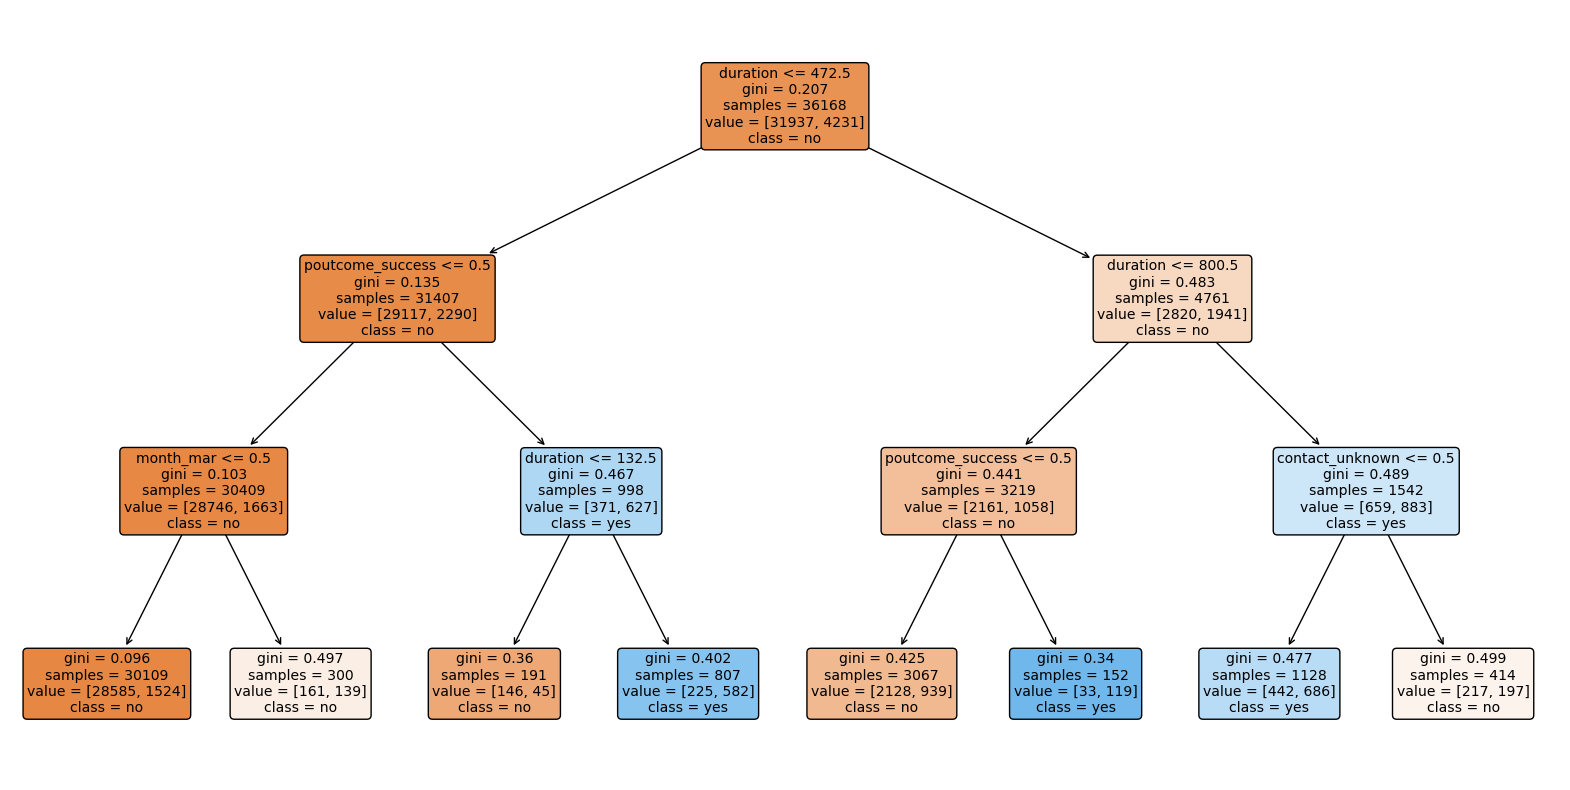

In [53]:
m3_depth3 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, criterion='gini')
m3_depth3.fit(x_train, y_train)

# Visualization
plt.figure(figsize=(20,10))
plot_tree(m3_depth3, feature_names=x_train.columns, class_names=m3_depth3.classes_, filled=True, rounded=True)
plt.show()

(4) Train decision tree models by different maximum depth (1, 2, 3, 4, 5) with min_samples_leaf = 10 and the entropy impurity for the criterion to determine the best split, using a training set (x_train, y_train). Then, calculate the accuracy of the models using a validation set (x_valid, y_valid) for overall samples and individual classes, and fill the following table.

In [ ]:
for max_depth in max_depths:
    m4 = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=10, criterion='entropy')
    m4.fit(x_train, y_train)
    models[max_depth] = m4
    
results = []

for max_depth, m4 in models.items():
    y_pred = m4.predict(x_valid)
    
    overall_accuracy = sum(y_pred == y_valid) / len(y_valid)
    
    class_accuracies = {}
    for cls in set(y_valid):
        class_mask = (y_valid == cls)
        class_accuracies[cls] = sum(y_pred[class_mask] == y_valid[class_mask]) / sum(class_mask)
    
    results.append((max_depth, overall_accuracy, class_accuracies))

columns = ['Max Depth', 'Overall Accuracy'] + [f'Class {cls} Accuracy' for cls in set(y_valid)]
data = []

for max_depth, overall_accuracy, class_accuracies in results:
    row = [max_depth, overall_accuracy] + [class_accuracies[cls] for cls in set(y_valid)]
    data.append(row)

results_df = pd.DataFrame(data, columns=columns)

results_df.to_csv('model_results_entropy1.csv', index=False)


In [59]:
m4_depth_2 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=10, criterion='entropy')
m4_depth_2.fit(x_train, y_train)

m4_depth_3 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, criterion='entropy')
m4_depth_3.fit(x_train, y_train)

def calculate_accuracy(model, x_valid, y_valid):
    y_pred = model.predict(x_valid)
    overall_accuracy = sum(y_pred == y_valid) / len(y_valid)
    
    class_accuracies = {}
    for cls in set(y_valid):
        class_mask = (y_valid == cls)
        class_accuracies[cls] = sum(y_pred[class_mask] == y_valid[class_mask]) / sum(class_mask)
    
    return overall_accuracy, class_accuracies

results = []

overall_accuracy_2, class_accuracies_2 = calculate_accuracy(m4_depth_2, x_valid, y_valid)
results.append((2, overall_accuracy_2, class_accuracies_2['no'], class_accuracies_2['yes']))

overall_accuracy_3, class_accuracies_3 = calculate_accuracy(m4_depth_3, x_valid, y_valid)
results.append((3, overall_accuracy_3, class_accuracies_3['no'], class_accuracies_3['yes']))

columns = ['Max Depth', 'Overall Accuracy', 'Class No Accuracy', 'Class Yes Accuracy']
results_df = pd.DataFrame(results, columns=columns)

results_df.to_csv('entropy_model_accuracies.csv', index=False)


# 3. k-means clustering

This problem uses data generated from several normal distributions to apply k-means clustering.

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [65]:
df = pd.read_csv("./syn_unbalance.csv", header=None)
df.shape

(6500, 2)

In [66]:
x = df.to_numpy()

(1) Select randomly k(=3, ..., 10) samples from the given dataset and use them as initial centroids. This procedure is repeated for 10 times for each k. You need to report the average and standard deviation of silhouette coefficient values of 10 iterations for each k.

In [104]:
silhouette_avg_list = []
silhouette_std_list = []

for k in range(3, 11):
    silhouette_scores = []
    for _ in range(10):
        np.random.seed(_)  # for reproducibility
        centroids_idx = np.random.choice(len(x), size=k, replace=False)
        initial_centroids = x[centroids_idx]
        
        kmeans = KMeans(n_clusters=k, init=initial_centroids, n_init=1)
        kmeans.fit(x)
        
        silhouette_score_value = silhouette_score(x, kmeans.labels_)
        silhouette_scores.append(silhouette_score_value)
        
    silhouette_avg = np.mean(silhouette_scores)
    silhouette_std = np.std(silhouette_scores)
    silhouette_avg_list.append(silhouette_avg)
    silhouette_std_list.append(silhouette_std)

In [105]:
random_centroids = initial_centroids

In [75]:
result_df = pd.DataFrame({
    'k': range(3, 11),
    'Average Silhouette Score': silhouette_avg_list,
    'Standard Deviation': silhouette_std_list
})

result_df['Avg (std)'] = result_df.apply(lambda row: f"{row['Average Silhouette Score']:.2f} ({row['Standard Deviation']:.2f})", axis=1)
result_df[['k', 'Avg (std)']].to_csv('./silhouette_scores_avg_std.csv', index=False)

(2) Use the default initialization strategy "k-means++". This procedure is repeated for 10 times. Then, calculate the average and standard deviation silhouette coefficient values of 10 iterations for each k.

In [77]:
silhouette_avg_list_kmpp = []
silhouette_std_list_kmpp = []

for k in range(3, 11):
    silhouette_scores_kmpp = []
    for _ in range(10):
        kmeans_kmpp = KMeans(n_clusters=k, init='k-means++', n_init=1)
        kmeans_kmpp.fit(x)
        
        silhouette_score_kmpp = silhouette_score(x, kmeans_kmpp.labels_)
        silhouette_scores_kmpp.append(silhouette_score_kmpp)
        
    silhouette_avg_kmpp = np.mean(silhouette_scores_kmpp)
    silhouette_std_kmpp = np.std(silhouette_scores_kmpp)
    silhouette_avg_list_kmpp.append(silhouette_avg_kmpp)
    silhouette_std_list_kmpp.append(silhouette_std_kmpp)

In [79]:
for k, silhouette_avg_kmpp, silhouette_std_kmpp in zip(range(3, 11), silhouette_avg_list_kmpp, silhouette_std_list_kmpp):
    print(f"For k = {k}, Average Silhouette Score (k-means++): {silhouette_avg_kmpp:.2f}, Standard Deviation: {silhouette_std_kmpp:.2f}")

For k = 3, Average Silhouette Score (k-means++): 0.65, Standard Deviation: 0.00
For k = 4, Average Silhouette Score (k-means++): 0.78, Standard Deviation: 0.11
For k = 5, Average Silhouette Score (k-means++): 0.83, Standard Deviation: 0.00
For k = 6, Average Silhouette Score (k-means++): 0.82, Standard Deviation: 0.05
For k = 7, Average Silhouette Score (k-means++): 0.85, Standard Deviation: 0.00
For k = 8, Average Silhouette Score (k-means++): 0.86, Standard Deviation: 0.00
For k = 9, Average Silhouette Score (k-means++): 0.74, Standard Deviation: 0.07
For k = 10, Average Silhouette Score (k-means++): 0.55, Standard Deviation: 0.07


In [81]:
result_df_kmpp = pd.DataFrame({
    'k': range(3, 11),
    'Average Silhouette Score (k-means++)': silhouette_avg_list_kmpp,
    'Standard Deviation (k-means++)': silhouette_std_list_kmpp
})

result_df_kmpp['Avg (std) (k-means++)'] = result_df_kmpp.apply(lambda row: f"{row['Average Silhouette Score (k-means++)']:.2f} ({row['Standard Deviation (k-means++)']:.2f})", axis=1)
result_df_kmpp[['k', 'Avg (std) (k-means++)']].to_csv('./silhouette_scores_kmpp_avg_std.csv', index=False)


(3) Draw scatter plots for the given data with initial centroids and final centroids for the worst and best number of clusters among k=3,...,10 in (1) in terms of silhouette coefficient. The final centroids should be marked as blue "X".

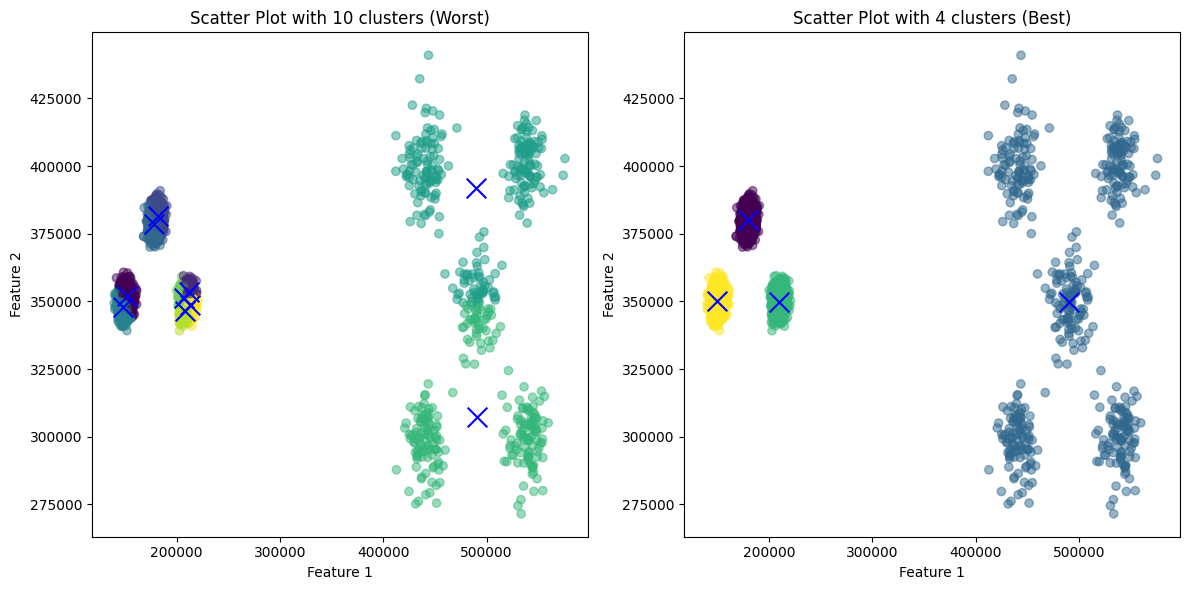

In [107]:
worst_idx = silhouette_avg_list.index(min(silhouette_avg_list))
best_idx = silhouette_avg_list.index(max(silhouette_avg_list))

worst_kmeans = KMeans(n_clusters=worst_idx + 3, init='random', n_init=10)
best_kmeans = KMeans(n_clusters=best_idx + 3, init='random', n_init=10)

worst_kmeans.fit(x)
best_kmeans.fit(x)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 1], c=worst_kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(worst_kmeans.cluster_centers_[:, 0], worst_kmeans.cluster_centers_[:, 1], marker='x', c='blue', s=200)
plt.title(f'Scatter Plot with {worst_kmeans.n_clusters} clusters (Worst)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(x[:, 0], x[:, 1], c=best_kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 1], marker='x', c='blue', s=200)
plt.title(f'Scatter Plot with {best_kmeans.n_clusters} clusters (Best)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()


(4) Draw scatter plots for the worst and best number of clusters among k=3,...,10 of question (2) in the same way as in question (3). Do not need to plot initial centroids.

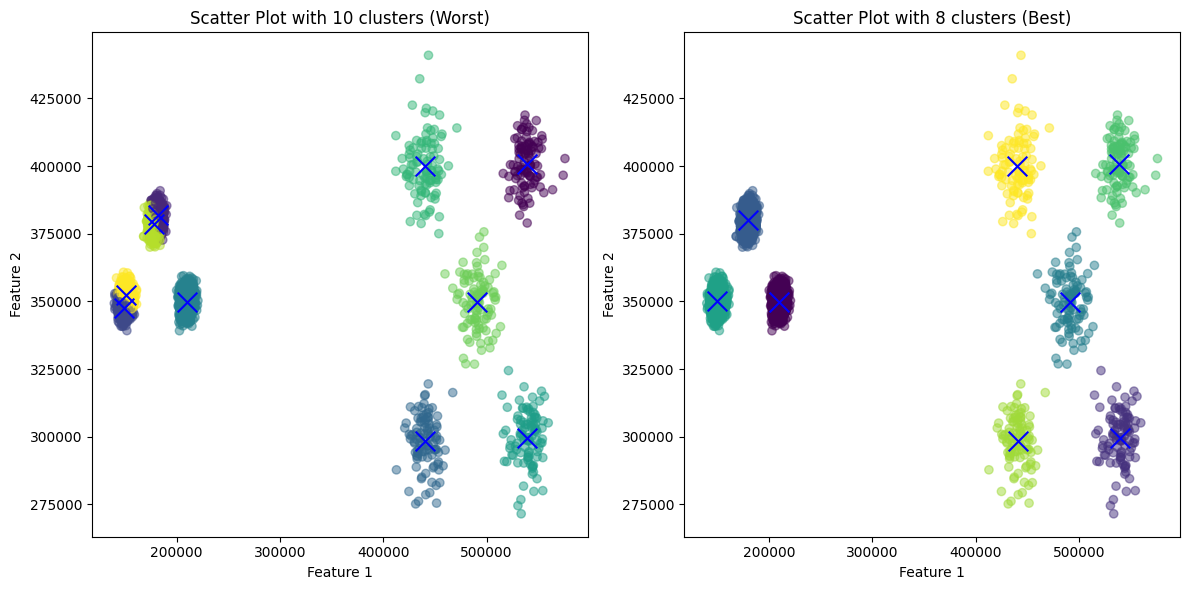

In [108]:
best_idx_kmpp = silhouette_avg_list_kmpp.index(max(silhouette_avg_list_kmpp))
worst_idx_kmpp = silhouette_avg_list_kmpp.index(min(silhouette_avg_list_kmpp))

best_kmeans_kmpp = KMeans(n_clusters=best_idx_kmpp + 3, init='k-means++', n_init=10)
worst_kmeans_kmpp = KMeans(n_clusters=worst_idx_kmpp + 3, init='k-means++', n_init=10)

best_kmeans_kmpp.fit(x)
worst_kmeans_kmpp.fit(x)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 1], c=worst_kmeans_kmpp.labels_, cmap='viridis', alpha=0.5)
plt.scatter(worst_kmeans_kmpp.cluster_centers_[:, 0], worst_kmeans_kmpp.cluster_centers_[:, 1], marker='x', c='blue', s=200)
plt.title(f'Scatter Plot with {worst_kmeans_kmpp.n_clusters} clusters (Worst)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(x[:, 0], x[:, 1], c=best_kmeans_kmpp.labels_, cmap='viridis', alpha=0.5)
plt.scatter(best_kmeans_kmpp.cluster_centers_[:, 0], best_kmeans_kmpp.cluster_centers_[:, 1], marker='x', c='blue', s=200)
plt.title(f'Scatter Plot with {best_kmeans_kmpp.n_clusters} clusters (Best)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()